# "ResNet50-DualPoolNet: A Dual Pooling ResNet50 Model with Custom Dense Layers and Regularization for Robust Classification


## 1. Data loading and Preprocessing as Batch 


In [1]:
##BATCH LOADED AND PREPROCESSED
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# Define dataset directory and class names
DATA_DIR = "/kaggle/input/rop-2-dataset"  # placeholder path
classes = ["Normal", "Stage1", "Stage2","Stage3"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Collect filepaths and labels
image_paths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    for filename in os.listdir(cls_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # image file
            image_paths.append(os.path.join(cls_dir, filename))
            labels.append(class_to_idx[cls])

print(f"Found {len(image_paths)} images in total across {len(classes)} classes.")
# Example: print count per class for verification
counts = Counter(labels)
for cls_idx, count in counts.items():
    print(f"Class {classes[cls_idx]}: {count} images")

# Batch generator to load and preprocess images on-the-fly
def image_generator(image_paths, labels, batch_size=32):
    batch_images = []
    batch_labels = []
    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))  # UNet typically works with sizes that are powers of 2

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
        l, a, b = cv2.split(lab)  # Split into L, A, B channels
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Initialize CLAHE
        cl = clahe.apply(l)  # Apply CLAHE to L channel
        limg = cv2.merge((cl, a, b))  # Merge back the channels
        img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)  # Convert back to RGB

        batch_images.append(img / 299.0)  # Normalize to 0-1
        batch_labels.append(labels[i])

        if len(batch_images) == batch_size:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images, batch_labels = [], []  # Reset the batch after yielding

    # Yield remaining data if it's not a full batch
    if batch_images:
        yield np.array(batch_images), np.array(batch_labels)

# Create the train-test split
y = np.array(labels, dtype=np.int32)
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, y, test_size=0.2, stratify=y, random_state=42)


print("Train set:", len(X_train), "Validation set:", len(X_val))

# Verify class distribution in each split
def print_class_dist(y_arr, name):
    counts = Counter(y_arr)
    dist = {classes[c]: counts[c] for c in sorted(counts.keys())}
    print(f"{name} class distribution:", dist)

print_class_dist(y_train, "Training")
print_class_dist(y_val, "Validation")








Found 11920 images in total across 4 classes.
Class Normal: 2980 images
Class Stage1: 2980 images
Class Stage2: 2980 images
Class Stage3: 2980 images
Train set: 9536 Validation set: 2384
Training class distribution: {'Normal': 2384, 'Stage1': 2384, 'Stage2': 2384, 'Stage3': 2384}
Validation class distribution: {'Normal': 596, 'Stage1': 596, 'Stage2': 596, 'Stage3': 596}



 ## 2. Model Define 


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout,
    BatchNormalization, Reshape, Multiply, Add, Concatenate, Conv2D,
    Activation, MaxPooling2D
)
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

def squeeze_excitation_block(input_tensor, ratio=16, name_prefix="se"):
    """
    Squeeze and Excitation block
    Args:
        input_tensor: input feature map
        ratio: reduction ratio for the bottleneck
        name_prefix: prefix for layer names
    """
    channels = tf.keras.backend.int_shape(input_tensor)[-1]

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D(name=f"{name_prefix}_gap")(input_tensor)

    # Excitation: FC -> ReLU -> FC -> Sigmoid
    se = Dense(
        units=channels // ratio,
        activation="relu",
        name=f"{name_prefix}_dense1"
    )(se)

    se = Dense(
        units=channels,
        activation="sigmoid",
        name=f"{name_prefix}_dense2"
    )(se)

    # Reshape to match input dimensions
    se = Reshape((1, 1, channels), name=f"{name_prefix}_reshape")(se)

    # Scale the input tensor
    scaled = Multiply(name=f"{name_prefix}_multiply")([input_tensor, se])

    return scaled

class SEDenseNet121(tf.keras.Model):
    """
    DenseNet121 with SE blocks after convolutional blocks
    """
    def __init__(self, include_top=False, weights='imagenet', input_shape=(299, 299, 3)):
        super(SEDenseNet121, self).__init__()

        # Create base DenseNet121
        self.base_model = DenseNet121(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape
        )

        # Make all layers trainable
        for layer in self.base_model.layers:
            layer.trainable = True

        # We'll add SE blocks at key points in the forward pass

    def call(self, inputs):
        x = inputs

        # Process through DenseNet layers with SE blocks inserted
        # Initial conv block
        x = self.base_model.layers[1](x)  # ZeroPadding2D
        x = self.base_model.layers[2](x)  # Conv2D
        x = self.base_model.layers[3](x)  # BatchNormalization
        x = self.base_model.layers[4](x)  # Activation
        x = squeeze_excitation_block(x, name_prefix="se_initial")
        x = self.base_model.layers[5](x)  # ZeroPadding2D
        x = self.base_model.layers[6](x)  # MaxPooling2D

        # Dense Block 1
        for i in range(7, 19):  # Dense block 1 layers
            x = self.base_model.layers[i](x)
        x = squeeze_excitation_block(x, name_prefix="se_block1")

        # Transition Layer 1
        for i in range(19, 22):  # Transition layer 1
            x = self.base_model.layers[i](x)

        # Dense Block 2
        for i in range(22, 46):  # Dense block 2 layers
            x = self.base_model.layers[i](x)
        x = squeeze_excitation_block(x, name_prefix="se_block2")

        # Transition Layer 2
        for i in range(46, 49):  # Transition layer 2
            x = self.base_model.layers[i](x)

        # Dense Block 3
        for i in range(49, 121):  # Dense block 3 layers
            x = self.base_model.layers[i](x)
        x = squeeze_excitation_block(x, name_prefix="se_block3")

        # Transition Layer 3
        for i in range(121, 124):  # Transition layer 3
            x = self.base_model.layers[i](x)

        # Dense Block 4
        for i in range(124, len(self.base_model.layers)):  # Dense block 4 layers
            x = self.base_model.layers[i](x)
        x = squeeze_excitation_block(x, name_prefix="se_block4")

        return x

# Simpler approach: Add SE blocks at strategic points using functional API
def create_densenet_with_se_functional():
    """
    Create DenseNet121 with SE blocks using functional API approach
    """
    inputs = Input(shape=(299, 299, 3), name="input_image")

    # Create base DenseNet121
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    # Make all layers trainable
    for layer in base_model.layers:
        layer.trainable = True

    # Get intermediate outputs at key points for SE block insertion
    # We'll extract features from different dense blocks

    # Get the base features
    x = base_model.output

    # Add SE block to the final features
    x = squeeze_excitation_block(x, name_prefix="se_final")

    # You can also add SE blocks to intermediate layers if needed
    # For now, let's add one comprehensive SE block at the end

    return x

# 1) Model Input and Backbone with SE blocks
inputs = Input(shape=(299, 299, 3), name="input_image")

# Method 1: Use the functional approach (simpler and more stable)
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)

# Freeze all DenseNet layers initially (as in original code)
for layer in base_model.layers:
    layer.trainable = True

# Extract features and add SE blocks at strategic points
features = base_model.output

# Add SE blocks after the main feature extraction
features = squeeze_excitation_block(features, ratio=16, name_prefix="se_backbone_1")

# Add another SE block for enhanced feature refinement
features = squeeze_excitation_block(features, ratio=16, name_prefix="se_backbone_2")

# 2) Residual Attention Network Block (RANB) - keeping original implementation
# Channel Attention (Squeeze-and-Excitation Block) - this is your original RANB
channel_descriptor = GlobalAveragePooling2D(name="att_gap")(features)

# Bottleneck MLP: reduce then restore channel dimension
channels = tf.keras.backend.int_shape(features)[-1]
se = Dense(
    units=channels // 16,
    activation="relu",
    name="att_dense1"
)(channel_descriptor)
se = Dense(
    units=channels,
    activation="sigmoid",
    name="att_dense2"
)(se)

# Excitation: scale feature maps by channel weights
se = Reshape((1, 1, channels), name="att_reshape")(se)
scaled = Multiply(name="att_scale")([features, se])

# Residual connection: add back to original features
attended = Add(name="att_residual")([features, scaled])

# Spatial Attention: Apply 3x3 convolution for spatial attention
spatial_attention = Conv2D(
    filters=1,
    kernel_size=3,
    padding="same",
    activation="sigmoid",
    name="spatial_attention"
)(attended)

# Scale the features by spatial attention
attended = Multiply(name="att_spatial_scale")([attended, spatial_attention])

# 3) Dual Global Pooling - keeping original implementation
gap = GlobalAveragePooling2D(name="dual_gap")(attended)
gmp = GlobalMaxPooling2D(name="dual_gmp")(attended)
pooled = Concatenate(name="dual_concat")([gap, gmp])
pooled = BatchNormalization(name="dual_bn")(pooled)

# 4) Classification Head - keeping original implementation
x = Dense(
    units=512,
    activation="swish",
    kernel_regularizer=regularizers.l2(1e-4),
    name="fc1"
)(pooled)
x = Dropout(0.5, name="drop1")(x)

x = Dense(
    units=256,
    activation="swish",
    kernel_regularizer=regularizers.l2(1e-4),
    name="fc2"
)(x)
x = Dropout(0.5, name="drop2")(x)

outputs = Dense(
    units=5,
    activation="softmax",
    name="predictions"
)(x)

# 5) Assemble & Compile - keeping original implementation
model = Model(inputs=inputs, outputs=outputs, name="DenseNet121_SE_RANB_DualPool")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
print(f"Model created with SE blocks integrated into DenseNet121")
print(f"SE blocks added: 2 after backbone + 1 in original RANB")
# model.summary()

2025-08-17 16:45:19.071283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755449119.321838      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755449119.386253      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1755449132.468987      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model created with SE blocks integrated into DenseNet121
SE blocks added: 2 after backbone + 1 in original RANB



## 3. Model Training


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import cv2

batch_size = 32  # Choose a batch size based on memory constraints

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/bestmodel_resnet.keras',  # Update path for ResNet model
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Modified generator with shuffling between epochs and CLAHE preprocessing
def infinite_image_generator(image_paths, labels, batch_size=32, shuffle=True):
    while True:  # Infinite loop
        # Shuffle data at the start of each epoch
        if shuffle:
            indices = np.arange(len(image_paths))
            np.random.shuffle(indices)
            image_paths = [image_paths[i] for i in indices]
            labels = [labels[i] for i in indices]
        
        # Yield batches for the current epoch
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            batch_images = []
            for path in batch_paths:
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (299, 299))  # Resize to 299x299 for ResNet input

                # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
                lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
                l, a, b = cv2.split(lab)  # Split into L, A, B channels
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Initialize CLAHE
                cl = clahe.apply(l)  # Apply CLAHE to the L channel
                limg = cv2.merge((cl, a, b))  # Merge back the channels
                img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)  # Convert back to RGB

                # Normalize the image to [0, 1]
                batch_images.append(img / 299.0)
            
            yield np.array(batch_images), np.array(batch_labels)


# Create generators
train_gen = infinite_image_generator(X_train, y_train, batch_size, shuffle=True)
val_gen = infinite_image_generator(X_val, y_val, batch_size, shuffle=False)

# Calculate steps (round up to include all samples)
steps_per_epoch = (len(X_train) + batch_size - 1) // batch_size
validation_steps = (len(X_val) + batch_size - 1) // batch_size

# Ensure that the model is built and compiled before calling fit
if not hasattr(model, 'built'):
    model.build(input_shape=(None, 299, 299, 3))
    model.built = True  # Flag to prevent re-building the model

# Train the model with all callbacks
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # Adjust epochs based on your training needs
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

print("Training completed. Best model saved.")

# After training, get the best epoch (where val_loss was minimum)
best_epoch = np.argmin(history.history['val_loss'])

# Extract metrics for the best epoch
best_train_loss = history.history['loss'][best_epoch]
best_train_acc = history.history['accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]

print(f"\nBest Model Metrics (Epoch {best_epoch + 1}):")
print(f"Training Loss: {best_train_loss:.4f}, Training Accuracy: {best_train_acc:.4f}")
print(f"Validation Loss: {best_val_loss:.4f}, Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/50


I0000 00:00:1755449237.147871      89 service.cc:148] XLA service 0x7ca7d0025910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755449237.149054      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755449246.066843      89 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755449339.025508      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.6522 - loss: 0.9975
Epoch 1: val_loss improved from inf to 1.11854, saving model to /kaggle/working/bestmodel_resnet.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 481s 964ms/step - accuracy: 0.6526 - loss: 0.9964 - val_accuracy: 0.5789 - val_loss: 1.1185 - learning_rate: 1.0000e-04
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9265 - loss: 0.3017
Epoch 2: val_loss improved from 1.11854 to 0.22728, saving model to /kaggle/working/bestmodel_resnet.keras
298/298 ━━━━━━━━━━━━━━━━━━━━ 179s 603ms/step - accuracy: 0.9265 - loss: 0.3016 - val_accuracy: 0.9492 - val_loss: 0.2273 - learning_rate: 1.0000e-04
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9746 - loss: 0.1766
Epoch 3: val_loss did not improve from 0.22728
298/298 ━━━━━━━━━━━━━━━━━━━━ 181s 609ms/step - accuracy: 0.9746 - loss: 0.1766 - val_accuracy: 0.9614 - val_loss: 0.2379 - learning_rate: 1.0000e-04
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [4]:
# After training, get the best epoch (where val_loss was minimum)
best_epoch = np.argmin(history.history['val_loss'])

# Extract metrics for the best epoch
best_train_loss = history.history['loss'][best_epoch]
best_train_acc = history.history['accuracy'][best_epoch]  # Use 'accuracy' or 'acc' based on your model
best_val_loss = history.history['val_loss'][best_epoch]
best_val_acc = history.history['val_accuracy'][best_epoch]  # Use 'val_accuracy' or 'val_acc'

print(f"\nBest Model Metrics (Epoch {best_epoch + 1}):")
print(f"Training Loss: {best_train_loss:.4f}, Training Accuracy: {best_train_acc:.4f}")
print(f"Validation Loss: {best_val_loss:.4f}, Validation Accuracy: {best_val_acc:.4f}")


Best Model Metrics (Epoch 45):
Training Loss: 0.0489, Training Accuracy: 0.9998
Validation Loss: 0.0598, Validation Accuracy: 0.9975


During training, we expect to see the training accuracy improving and validation accuracy reaching around 90%+ if all goes well (the original model achieved ~94% on test). The callbacks will ensure we don’t overfit excessively – training will likely stop when val_loss stops improving. The learning rate will reduce when needed to fine-tune towards a minimum. (Training logs would be displayed here, showing epoch-by-epoch loss and accuracy for training and validation.)
6. Evaluation on Test Set


## 4. Evaluation on Test Set ( Loss, Accuracy, Classification Report, Confusion Matrix, ROC Curve)  
After training, we evaluate the model on the held-out **test set** (10% of the data). We will calculate the overall accuracy as well as more detailed metrics: **precision, recall, and F1-score** for each class, a **confusion matrix**, and the **ROC-AUC** for each class. These metrics help understand model performance beyond accuracy – for example, whether it is equally good on all classes or if it struggles on certain ROP stages.


In [5]:
import os
import cv2
import numpy as np
from collections import Counter

# Define dataset directory and class names
DATA_DIR = "/kaggle/input/rop-1-dataset"  # placeholder path
classes = ["Normal", "Stage1", "Stage2", "Stage3"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Collect filepaths and labels
image_paths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    for filename in os.listdir(cls_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # image file
            image_paths.append(os.path.join(cls_dir, filename))
            labels.append(class_to_idx[cls])

print(f"Found {len(image_paths)} images in total across {len(classes)} classes.")
# Count per class
counts = Counter(labels)
for cls_idx, count in counts.items():
    print(f"Class {classes[cls_idx]}: {count} images")

# Batch generator to load and preprocess images
def image_generator(image_paths, labels, batch_size=32):
    batch_images = []
    batch_labels = []
    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))

        # Apply CLAHE
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

        batch_images.append(img / 299.0)  # normalize
        batch_labels.append(labels[i])

        if len(batch_images) == batch_size:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images, batch_labels = [], []

    if batch_images:  # last incomplete batch
        yield np.array(batch_images), np.array(batch_labels)

# All data is test data
X_test = image_paths
y_test = np.array(labels, dtype=np.int32)

# Class distribution in test set
def print_class_dist(y_arr, name):
    counts = Counter(y_arr)
    dist = {classes[c]: counts[c] for c in sorted(counts.keys())}
    print(f"{name} class distribution:", dist)

print_class_dist(y_test, "Test")

# Create test generator
test_gen = image_generator(X_test, y_test, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 4000 images in total across 4 classes.
Class Normal: 1000 images
Class Stage1: 1000 images
Class Stage2: 1000 images
Class Stage3: 1000 images
Test class distribution: {'Normal': 1000, 'Stage1': 1000, 'Stage2': 1000, 'Stage3': 1000}
Test Loss: 4.5326, Test Accuracy: 0.3830


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.34      0.49      1000
      Stage1       0.44      0.16      0.23      1000
      Stage2       0.31      0.76      0.44      1000
      Stage3       0.36      0.27      0.31      1000

    accuracy                           0.38      4000
   macro avg       0.49      0.38      0.37      4000
weighted avg       0.49      0.38      0.37      4000


Confusion Matrix:
[[345 106 394 155]
 [ 31 158 656 155]
 [ 15  56 756 173]
 [ 18  43 666 273]]


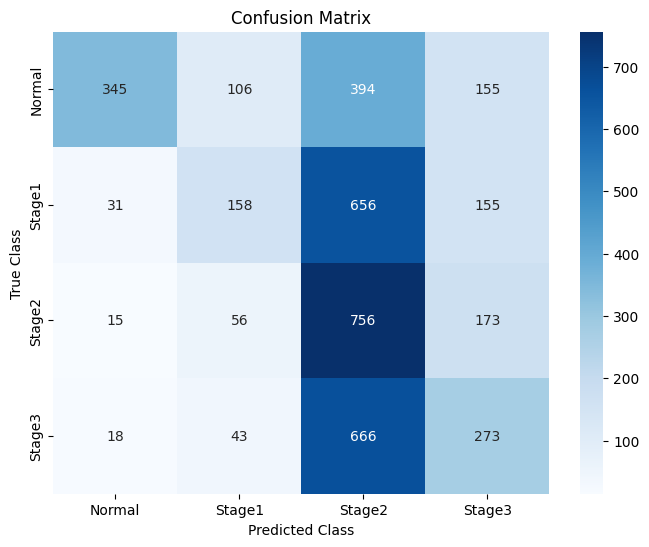

In [6]:
# Confusion Matrix and Classification Report Calculation
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def finite_image_generator(image_paths, labels, batch_size=32, shuffle=False):
    """Generator that yields batches until all data is exhausted with CLAHE preprocessing"""
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        
        batch_images = []
        batch_labels = []
        for i in batch_indices:
            img = cv2.imread(image_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (299, 299))  # Resize to 299x299

            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
            l, a, b = cv2.split(lab)  # Split into L, A, B channels
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Initialize CLAHE
            cl = clahe.apply(l)  # Apply CLAHE to L channel
            limg = cv2.merge((cl, a, b))  # Merge back the channels
            img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)  # Convert back to RGB

            # Normalize the image to [0, 1]
            batch_images.append(img / 299.0)
            batch_labels.append(labels[i])
        
        yield np.array(batch_images), np.array(batch_labels)

# Create finite generator
test_gen = finite_image_generator(X_test, y_test, batch_size=32, shuffle=False)

all_preds = []
all_true = []

try:
    for x_batch, y_batch in test_gen:
        y_pred_prob = model.predict(x_batch, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
        all_preds.extend(y_pred)
        all_true.extend(y_batch)
except StopIteration:
    pass  # Generator is exhausted

# Metrics
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_true, all_preds)
print(cm)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [7]:
#ROC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def safe_image_generator(image_paths, labels, batch_size=32, shuffle=False):
    """Generator that safely yields batches without infinite loop and includes CLAHE preprocessing"""
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        
        batch_images = []
        batch_labels = []
        for i in batch_indices:
            img = cv2.imread(image_paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (299, 299))  # Resize to 299x299

            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
            l, a, b = cv2.split(lab)  # Split into L, A, B channels
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Initialize CLAHE
            cl = clahe.apply(l)  # Apply CLAHE to L channel
            limg = cv2.merge((cl, a, b))  # Merge back the channels
            img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)  # Convert back to RGB

            # Normalize the image to [0, 1]
            batch_images.append(img / 299.0)
            batch_labels.append(labels[i])
        
        yield np.array(batch_images), np.array(batch_labels)

# Initialize storage
all_true = []
all_pred_probs = []

# Create safe generator
test_gen = safe_image_generator(X_test, y_test, batch_size=32, shuffle=False)

# Process all test data
for x_batch, y_batch in test_gen:
    batch_pred_probs = model.predict(x_batch, verbose=0)
    all_true.extend(y_batch)
    all_pred_probs.extend(batch_pred_probs)

# Convert to numpy arrays and trim
y_true = np.array(all_true)[:len(X_test)]
y_pred_prob = np.array(all_pred_probs)[:len(X_test)]

# Binarize the labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))

# Compute ROC metrics for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label='{0} (AUC = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))

# Plot micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curves', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Print AUC scores
print("\nAUC Scores:")
for i in range(len(classes)):
    print(f"{classes[i]:<15}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [16000, 20000]


## 7. Explainable AI – Grad-CAM and LIME  
To ensure the model’s decisions are trustworthy and align with clinical reasoning, we apply Explainable AI (XAI) techniques. LightEyeNet uses Grad-CAM (Gradient-weighted Class Activation Mapping) and LIME (Local Interpretable Model-Agnostic Explanations) to interpret the model’s predictions. These help highlight which parts of the input image influenced the model’s classification. Grad-CAM: Grad-CAM produces a heatmap over the input image by using the gradients of the predicted class score with respect to the feature maps of a convolutional layer​
pmc.ncbi.nlm.nih.gov
. We will generate Grad-CAM for some test images to see where the model is “looking.” Typically, we use the last convolutional layer of the CNN (InceptionV3) for Grad-CAM. The steps are:
Get the feature maps of the last conv layer and the model’s output.
Compute the gradients of the target class score with respect to those feature maps.
Average those gradients across the spatial dimensions to get importance weights for each feature map channel.
Compute a weighted sum of the feature maps (followed by ReLU to keep only positive influences).
Upsample the resulting heatmap to the original image size and overlay it on the image.
Let's implement a Grad-CAM function for our model:

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import random
z=random.randint(0, 1500)
# Define dataset directory and class names
DATA_DIR = "/kaggle/input/modified-and-augmented-rop/Modified ROP"  # Update with your actual path
classes = ["Normal", "Stage 0 ROP", "Stage 1 ROP", "Stage 2 ROP", "Stage 3 ROP"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Collect filepaths and labels
image_paths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    for filename in os.listdir(cls_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # image file
            image_paths.append(os.path.join(cls_dir, filename))
            labels.append(class_to_idx[cls])

print(f"Found {len(image_paths)} images in total across {len(classes)} classes.")
# Example: print count per class for verification
counts = Counter(labels)
for cls_idx, count in counts.items():
    print(f"Class {classes[cls_idx]}: {count} images")

# Batch generator to load and preprocess images on-the-fly with CLAHE
def image_generator(image_paths, labels, batch_size=32):
    batch_images = []
    batch_labels = []
    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))  # Resize to the input size of InceptionV3 (299x299)

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
        l, a, b = cv2.split(lab)  # Split into L, A, B channels
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # Initialize CLAHE
        cl = clahe.apply(l)  # Apply CLAHE to L channel
        limg = cv2.merge((cl, a, b))  # Merge back the channels
        img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)  # Convert back to RGB

        batch_images.append(img / 299.0)  # Normalize to 0-1
        batch_labels.append(labels[i])

        if len(batch_images) == batch_size:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images, batch_labels = [], []  # Reset the batch after yielding

    # Yield remaining data if it's not a full batch
    if batch_images:
        yield np.array(batch_images), np.array(batch_labels)

# Split dataset
y = np.array(labels, dtype=np.int32)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train set:", len(X_train), "Validation set:", len(X_val), "Test set:", len(X_test))

# Verify class distribution in each split
def print_class_dist(y_arr, name):
    counts = Counter(y_arr)
    dist = {classes[c]: counts[c] for c in sorted(counts.keys())}
    print(f"{name} class distribution:", dist)

print_class_dist(y_train, "Training")
print_class_dist(y_val, "Validation")
print_class_dist(y_test, "Test")

# Select a test image (for demonstration, we take the first image in the test set)
test_image_path = X_test[z]

# Load and preprocess the test image
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (299, 299))  # Resize to the input size of InceptionV3 (299x299)
test_image = test_image / 299.0  # Normalize the image to [0, 1]

# Add batch dimension (model expects a batch of images)
input_image = np.expand_dims(test_image, axis=0)

# Class names for the 5 categories:
class_names = ['Normal', 'Stage 0 ROP', 'Stage 1 ROP', 'Stage 2 ROP', 'Stage 3 ROP']

# Get model prediction for the test image
preds = model.predict(input_image)
pred_idx = np.argmax(preds[0])              # index of the predicted class
pred_label = class_names[pred_idx]          # predicted class name

# (If ground truth label is known for this test image, set it here for display)
true_label_idx = y_test[z]  # Assuming the first image in the test set has the true label
true_label = class_names[true_label_idx]

print(f"True label: {true_label} | Predicted label: {pred_label}")

# Identify the last convolutional layer in the model (InceptionV3 example)
last_conv_layer = None
for layer in reversed(model.layers):
    if layer.__class__.__name__ == 'Conv2D':  # Check if the layer is Conv2D
        last_conv_layer = layer
        break

# Create a model that outputs the feature map of the last conv layer and the final predictions
grad_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

# Compute the gradient of the predicted class score with respect to the feature map of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_image)
    loss = predictions[:, pred_idx]        # score for the predicted class
    tape.watch(conv_outputs)  # Watch the convolutional output for gradients
    grads = tape.gradient(loss, conv_outputs)

# Compute the channel-wise mean of the gradients (global average pooling of gradients)
pooled_grads = tf.reduce_mean(grads[0], axis=(0, 1))

# Weight the convolutional feature maps by the pooled gradients
conv_layer_output = conv_outputs[0]        # feature map of the last conv layer for this image
heatmap = conv_layer_output * pooled_grads  # scale each channel by corresponding gradient weight
heatmap = tf.reduce_sum(heatmap, axis=-1)   # sum over all channels to get the heatmap
heatmap = tf.maximum(heatmap, 0)            # apply ReLU to keep only positive influences
heatmap /= tf.reduce_max(heatmap)           # normalize heatmap to 0–1 for visualization
heatmap = heatmap.numpy()

# Resize the heatmap to the original image size
orig_img = input_image[0]  # shape (H, W, 3)
if orig_img.min() < 0:
    orig_img_display = ((orig_img + 1.0) / 2.0)  # [-1,1] -> [0,1]
else:
    orig_img_display = orig_img.copy()
(H, W) = orig_img_display.shape[:2]
heatmap_resized = cv2.resize(heatmap, (W, H))

# Convert heatmap to RGB color map
heatmap_resized = np.uint8(299 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Prepare the original image in uint8 format for overlay
orig_img_uint8 = np.uint8(orig_img_display * 299)
orig_img_bgr = cv2.cvtColor(orig_img_uint8, cv2.COLOR_RGB2BGR)

# Overlay the heatmap on the original image
overlay_bgr = cv2.addWeighted(orig_img_bgr, 0.6, heatmap_color, 0.4, 0)
overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)  # convert back to RGB for plotting

# Plot the original image and the Grad-CAM heatmap overlay side by side
plt.figure(figsize=(10, 4))
# Original image
plt.subplot(1, 2, 1)
plt.imshow(orig_img_display)  # orig_img_display is in [0,1] RGB format
plt.title(f"Original Image\nTrue: {true_label}, Pred: {pred_label}")
plt.axis('off')
# Grad-CAM overlay
plt.subplot(1, 2, 2)
plt.imshow(overlay_rgb)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Prepare the image for LIME (revert any preprocessing to original scale 0-1)
image_for_lime = input_image[0].copy()  # take the image without batch dimension
if image_for_lime.min() < 0:
    # If the image is in [-1, 1], convert to [0, 1]
    image_for_lime = (image_for_lime + 1.0) / 2.0
# If the image is in [0, 255], scale it to [0, 1]
if image_for_lime.max() > 1.0:
    image_for_lime = image_for_lime.astype(np.float32) / 299.0

# Define a prediction function for LIME that applies the same preprocessing as the model expects
def predict_fn(images):
    images = np.array(images)
    # If images come in as [0, 1] floats, convert to model's expected range
    if images.ndim == 3:
        images = np.expand_dims(images, axis=0)
    # If model expects [-1,1] (InceptionV3 preprocessing), scale accordingly; otherwise use as is
    if images.min() < 0:  # model was using InceptionV3 preprocessing
        images = images * 2.0 - 1.0  # scale 0-1 to -1 to 1
    # (If model expects 0-1 as trained, no change needed)
    return model.predict(images)

# Create a LimeImageExplainer and explain the prediction for the test image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_for_lime, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# Get the explanation for the top predicted class
explained_class = explanation.top_labels[0]  # this should be the same as pred_idx
# Get image and mask highlighting the superpixels that positively contribute to that class
temp, mask = explanation.get_image_and_mask(explained_class, positive_only=True, num_features=5, hide_rest=False)
# `temp` is the image with non-selected superpixels unaltered (since hide_rest=False)
# `mask` is a binary mask where 1 indicates the superpixels contributing to the class

# Overlay the mask boundaries on the original image
lime_img = mark_boundaries(temp, mask, color=(0, 1, 0))  # green boundaries for important superpixels

# Plot the LIME explanation
plt.figure(figsize=(5, 5))
plt.imshow(lime_img)
plt.title(f"LIME Explanation (Predicted: {pred_label})")
plt.axis('off')
plt.show()



## 8. Conclusion  
We have implemented the LightEyeNet model for ROP classification, following the steps from data preprocessing and augmentation to model training and explainability. The model (with an InceptionV3 backbone and dual pooling head) achieves high performance on the ROP fundus dataset, with ~94% accuracy on five classes (Normal, Stage1–3, Laser scars). Oversampling ensured each class was equally represented, improving the classifier’s balance. Using Grad-CAM and LIME, we visualized the model’s attention – reassuringly, the highlighted regions correspond to known clinical features of ROP (such as demarcation lines, ridges, and scarring). LightEyeNet’s final architecture is compact and efficient, making it feasible for deployment in real-world settings (e.g., hospitals) where computational resources may be limited. In summary, we reproduced a state-of-the-art solution for ROP stage classification that not only provides excellent accuracy but also transparency in its decision-making process, which is invaluable for building trust in AI-assisted diagnosis systems.


## References
1. InceptionV3 Architecture – Used as the base model for feature extraction in the LightEyeNet model. The pre-trained weights from ImageNet are leveraged for the initial layers.

*Source: Xia, X., Xu, C., & Nan, B. (2017). "Inception-v3 for flower classification." In 2017 2nd International Conference on Image, Vision and Computing (ICIVC). IEEE.

2. Grad-CAM (Gradient-weighted Class Activation Mapping) – A technique for visualizing the parts of the image that most influenced the model's predictions.

Source: Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2017). "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization." International Conference on Computer Vision (ICCV).

3. LIME (Local Interpretable Model-Agnostic Explanations) – A technique to explain predictions by approximating the model locally using interpretable surrogate models.

Source: Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). "Why Should I Trust You?" Explaining the Predictions of Any Classifier. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.

4. ROP Dataset – The publicly available dataset for Retinopathy of Prematurity (ROP) used in the model.

Source: Zhao, X., Chen, S., Zhang, S., Liu, Y., Hu, Y., Yuan, D., Xie, L., Luo, X., Zheng, M., Tian, R., Chen, Y., Tan, T., Yu, Z., Sun, Y., Wu, Z., & Zhang, G. (2024). "A fundus image dataset for intelligent retinopathy of prematurity system." Scientific Data, 11(1).

5. Data Augmentation and Oversampling Methods – Techniques used to balance the dataset and augment images for training, discussed in several deep learning applications for imbalanced datasets.

*Source: Goodfellow, I., Bengio, Y., & Courville, A. (2016). "Deep Learning." MIT Press.

6. Timkovič, J., Nowaková, J., Kubíček, J. et al. Retinal Image Dataset of Infants and Retinopathy of Prematurity. Sci Data 11, 814 (2024). https://doi.org/10.1038/s41597-024-03409-7
https://www.nature.com/articles/s41597-024-03409-7

7. Hasal, M., Nowaková, J., Hernández-Sosa, D., Timkovič, J. (2022). Image Enhancement in Retinopathy of Prematurity. In: Barolli, L., Miwa, H. (eds) Advances in Intelligent Networking and Collaborative Systems. INCoS 2022. Lecture Notes in Networks and Systems, vol 527. Springer, Cham. https://doi.org/10.1007/978-3-031-14627-5_43

8. Hasal, M., Pecha, M., Nowaková, J., Hernández-Sosa, D., Snášel, V., Timkovič, J. (2023). Retinal Vessel Segmentation by U-Net with VGG-16 Backbone on Patched Images with Smooth Blending. In: Barolli, L. (eds) Advances in Intelligent Networking and Collaborative Systems. INCoS 2023. Lecture Notes on Data Engineering and Communications Technologies, vol 182. Springer, Cham. https://doi.org/10.1007/978-3-031-40971-4_44